In [346]:
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 3.2MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=c34ccd461f6d1724c539d91d282a8fd0553ceff1cb8cc4d3cc6ff4f35d0c6b27
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=99b73aca33599a4e07ca92666915ef5c53f1e9634f6150e72c37523840ab9ec7
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


# Problema Regressão - Pressão em asas de aeronaves
### Bruno Monteiro Accioli da Silva e Genebaldo

In [347]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from kerastuner.tuners import RandomSearch

sns.set(style='whitegrid', font_scale=1.2)

In [11]:
dataset_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat'
columns=['frequency', 'angle', 'chord_length', 'velocity', 'suction_thickness', 
         'pressure']
df = pd.read_csv(dataset_url, sep='\t', header=None, names=columns)
df.head()

,frequency,angle,chord_length,velocity,suction_thickness,pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


## Análise Exploratória

### Distribuição das variáveis

[]

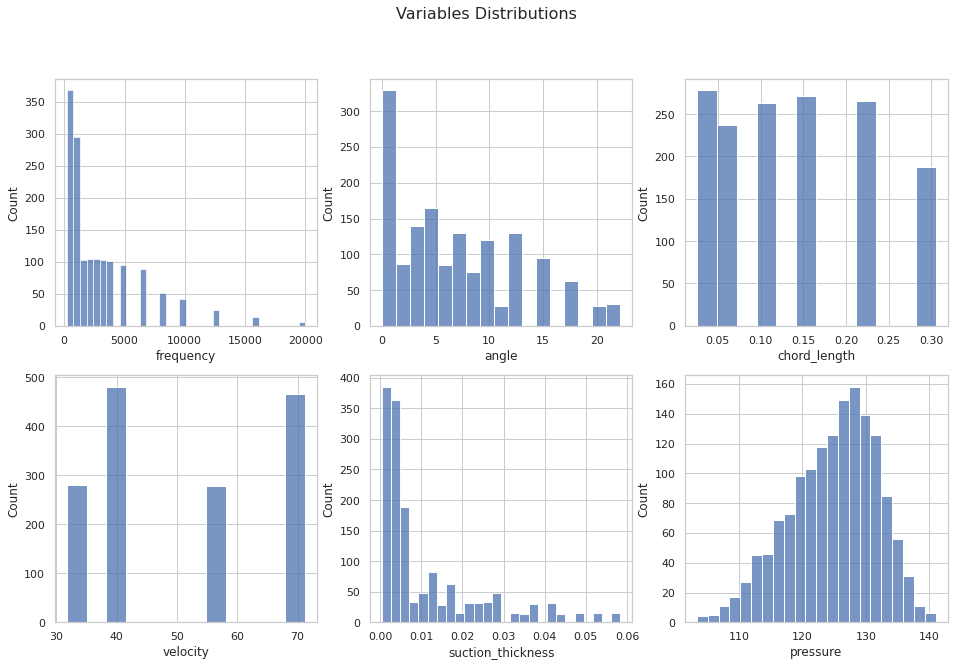

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,10))
lin=0
col=0
for i, column in enumerate(columns):
  if i <= 2:
    lin = 0
    col = i
  else:
    lin = 1
    col = i-3
  ax[lin,col] = sns.histplot(x=column , data=df, ax=ax[lin,col])
_ = fig.suptitle('Variables Distributions', size=16)
plt.plot()

### Avaliação de outliers

[]

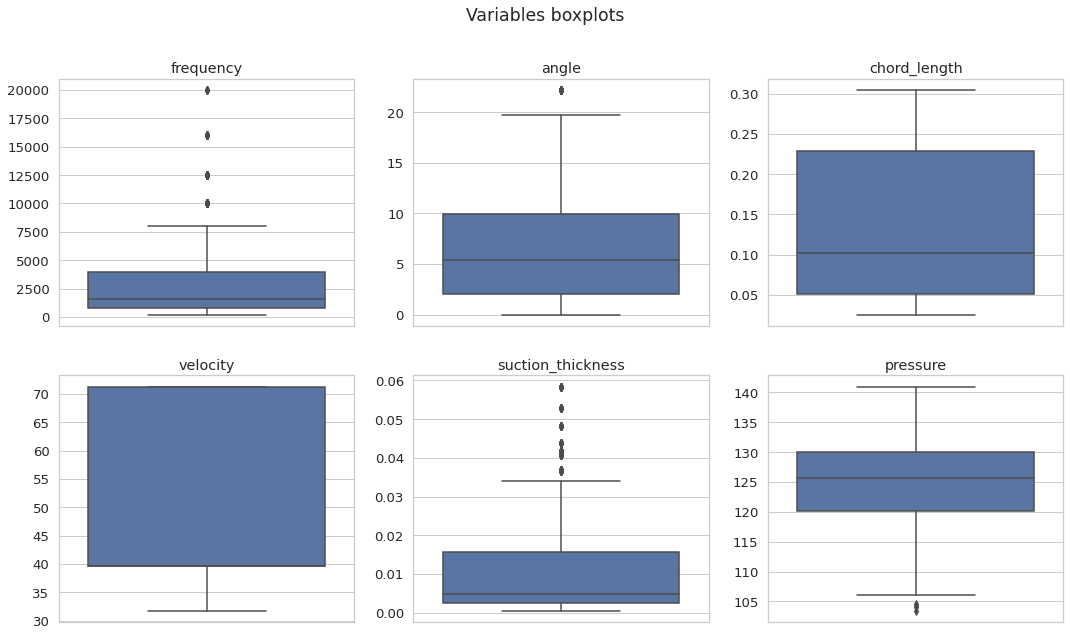

In [228]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
lin=0
col=0
for i, column in enumerate(columns):
  if i <= 2:
    lin = 0
    col = i
  else:
    lin = 1
    col = i-3
  _ = sns.boxplot(y=column, data=df, ax=ax[lin,col])
  ax[lin,col].set_ylabel('')
  ax[lin,col].set_title(column) 
_ = fig.suptitle('Variables boxplots')
plt.plot()

### Relação das variáveis de entrada com a variável de saída (pressão)

[]

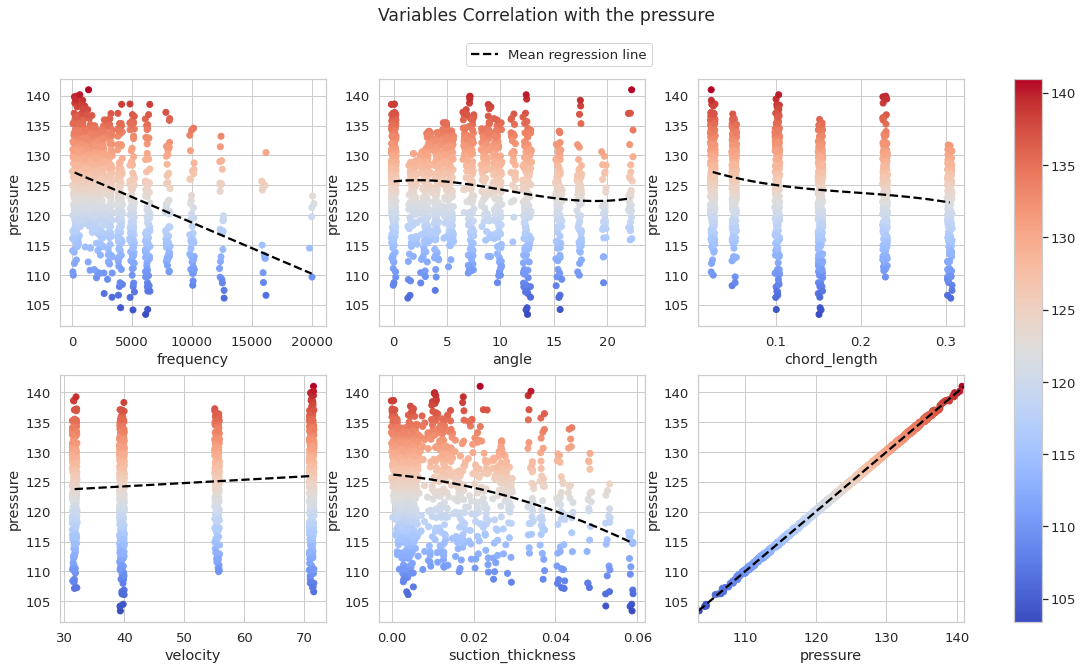

In [145]:
def add_jitter(variable, intensity=0.1):
  var_range = variable.max() - variable.min()
  noise = (intensity * var_range) * np.random.uniform(low=-1.0, high=1.0, size=len(variable))
  return variable + noise

reg_line_order = [1, 3, 3, 1, 2, 1]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
lin=0
col=0
for i, column in enumerate(columns):
  if i <= 2:
    lin = 0
    col = i
  else:
    lin = 1
    col = i-3
  collection = ax[lin,col].scatter(x=add_jitter(df[column], 0.01), 
                                  y=df['pressure'], c=df['pressure'],
                                  cmap='coolwarm', alpha=1)
  sns.regplot(x=column, y='pressure', data=df, ax=ax[lin,col],
              x_estimator=np.mean, x_bins=20, ci=None, marker=None, 
              order=reg_line_order[i], color='black', n_boot=1,
              scatter_kws={"alpha" : 0}, 
              line_kws={'linestyle':'--', 'label':'Mean regression line'}) 
_ = fig.suptitle('Variables Correlation with the pressure')
fig.colorbar(collection, ax=ax, orientation='vertical', fraction=.05)
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc = (0.43, 0.9))
plt.plot()

### Correlação das variáveis

Aqui medimos a correlação entre as variáveis utilizando o Coeficiente de correlação de postos de Spearman que é capaz de medir o quão bem uma função monotônica é capaz de descrever a relação entre duas variáveis. Os valores do coeficiente vão de -1 a +1, e uma relação monotônica perfeita terá valores de -1 ou +1, enquanto variáveis que não possuem nenhuma correlação monotônica possuirão o coeficiente igual a 0.

Os coeficientes de correlação obtidos permitem algumas conclusões:

- As variáveis suction_thickness e angle possuem uma correlação monotônica muito forte (0.88).
- As variáveis velocity e angle possuem correlação muito baixa com pressure.

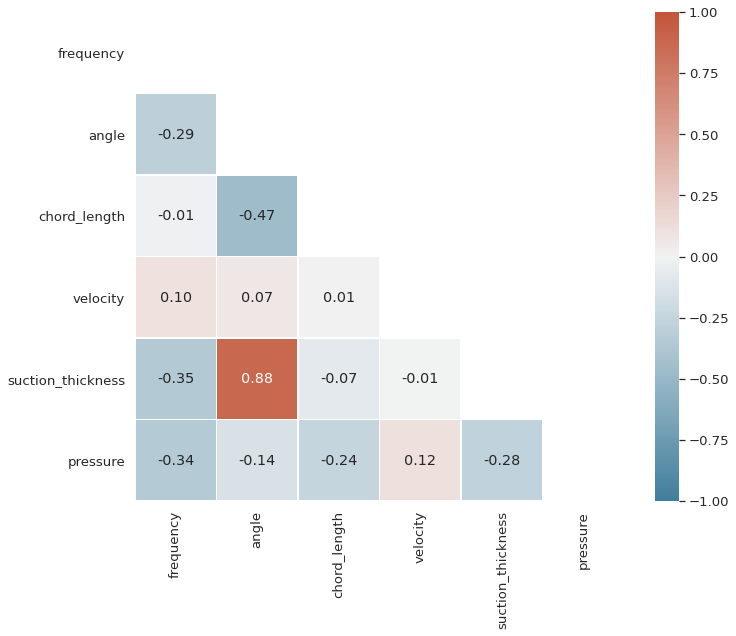

In [222]:
correlation_matrix = df.corr(method='spearman')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax = sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, 
                 center=0, annot=True, fmt=".2f", square=True, linewidths=.5, 
                  cbar_kws={"shrink": 1}, ax=ax)

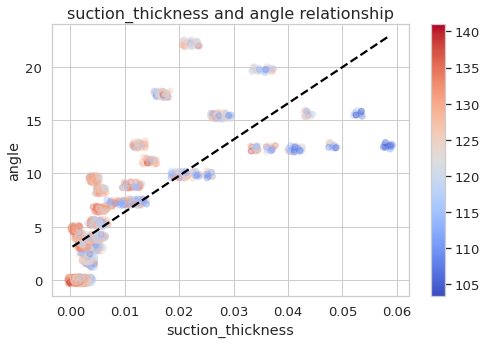

In [219]:
fig, ax = plt.subplots(figsize=(8, 5))

cmap = cm.coolwarm
ax = sns.regplot(x='suction_thickness', y='angle', data=df, scatter=False,
                 ci=None, line_kws={'color':'black', 'linestyle': '--', 
                                    'label':"Regression line"}, ax=ax)
collection = ax.scatter(x=add_jitter(df['suction_thickness'], 0.015), 
                        y=add_jitter(df['angle'], 0.015), alpha=0.3, 
                        c=df['pressure'], cmap=cmap)
_ = ax.set_title('suction_thickness and angle relationship', size=16)
color_bar = plt.colorbar(collection)
color_bar.set_alpha(1)
color_bar.draw_all()

### Verificação de valores faltantes

Verificamos abaixo que nenhuma das variáveis possui valores faltantes, logo não se faz necessário o tratamento dessa questão.

In [223]:
df.isna().sum()

frequency            0
angle                0
chord_length         0
velocity             0
suction_thickness    0
pressure             0
dtype: int64

## Treinamento de modelos

In [293]:
def plot_history(history, title=''):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  fig,ax = plt.subplots(figsize=(10,6))

  ax = sns.lineplot(x='epoch', y='mse', data=hist, label='Train Error', ax=ax)
  ax = sns.lineplot(x='epoch', y='val_mse', data=hist, label='Val Error', ax=ax)

  ax.set_ylim([0, max(hist['mse'].max(), hist['val_mse'].max())])
  ax.set_xlim([0, hist['epoch'].max()])
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.set_title(title, size=16)
  ax.set_xticks(hist['epoch'])

  plt.show()

Separando conjunto de dados em treino e teste

In [259]:
input_cols = ['frequency', 'angle', 'chord_length', 'velocity', 'suction_thickness']
target = 'pressure'

X = df[input_cols]
y = df[target].to_frame()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"\nX_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1052, 5)
y_train shape: (1052, 1)

X_test shape: (451, 5)
y_test shape: (451, 1)


Para facilitar a convergência do treinamento da rede que é feito através do algoritmo de gradiente descendente, é importante que as variáveis de entrada e saída tenham aproximadamente a mesma escala.

Por isso, a escala das variáveis será ajustada para facilitar a convergência através da técnica MinMaxScaler para que todas as variáveis passem a ter valor máximo igual a 1 e valor mínimo igual a 0.

In [260]:
print('Estatística das entradas do conjunto de treino antes do processo de normalização')
X_train.describe().loc[['mean', 'std', 'min', 'max'], :]

Estatística das entradas do conjunto de treino antes do processo de normalização


,frequency,angle,chord_length,velocity,suction_thickness
mean,2908.792776,6.898669,0.132891,51.448099,0.011127
std,3111.443492,5.910232,0.091777,15.776499,0.013022
min,200.000000,0.000000,0.025400,31.700000,0.000401
max,20000.000000,22.200000,0.304800,71.300000,0.058411


In [261]:
scaler_input = MinMaxScaler()
X_train = pd.DataFrame(scaler_input.fit_transform(X_train), columns=input_cols)
X_test = pd.DataFrame(scaler_input.transform(X_test), columns=input_cols)

scaler_output = MinMaxScaler()
y_train = pd.DataFrame(scaler_output.fit_transform(y_train), 
                       columns=[target])
y_test = pd.DataFrame(scaler_output.transform(y_test), 
                      columns=[target])

print('Estatística das entradas do conjunto de treino após o processo de normalização')
X_train.describe().loc[['mean', 'std', 'min', 'max'], :]

Estatística das entradas do conjunto de treino após o processo de normalização


,frequency,angle,chord_length,velocity,suction_thickness
mean,0.136808,0.310751,0.384722,0.498689,0.184908
std,0.157144,0.266227,0.328477,0.398396,0.224481
min,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [348]:
callbacks = []
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                                  restore_best_weights=True))
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='linear')
  ])

optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_34 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 129       
Total params: 17,409
Trainable params: 17,409
Non-trainable params: 0
_________________________________________________________________


In [349]:
history = model.fit(X_train, y_train, batch_size=50, epochs=30, 
                    validation_split=0.2, verbose=1, callbacks=callbacks)

Epoch 1/30
17/17 [==============================] - 1s 15ms/step - loss: 0.1529 - mse: 0.1529 - val_loss: 0.0464 - val_mse: 0.0464
Epoch 2/30
17/17 [==============================] - 0s 4ms/step - loss: 0.0403 - mse: 0.0403 - val_loss: 0.0270 - val_mse: 0.0270
Epoch 3/30
17/17 [==============================] - 0s 5ms/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 4/30
17/17 [==============================] - 0s 5ms/step - loss: 0.0185 - mse: 0.0185 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 5/30
17/17 [==============================] - 0s 4ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0160 - val_mse: 0.0160
Epoch 6/30
17/17 [==============================] - 0s 4ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0156 - val_mse: 0.0156
Epoch 7/30
17/17 [==============================] - 0s 4ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0151 - val_mse: 0.0151
Epoch 8/30
17/17 [==============================] - 0s 5ms/step - loss: 0.0142 - mse: 0.0

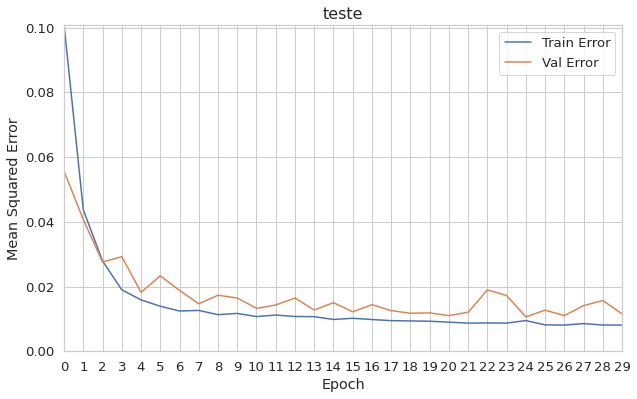

In [323]:
plot_history(history, 'teste')

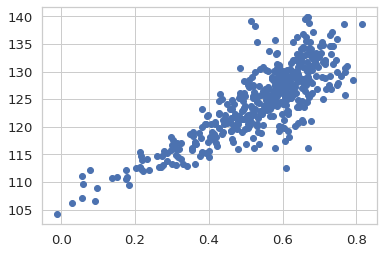

In [342]:
pred = model.predict(X_test)

plt.scatter(pred, scaler_output.inverse_transform(y_test))

In [ ]:
def build_model(hp):
  callbacks = []
  callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                                    restore_best_weights=True))

  n_layers = hp.Choice('n_hidden_layers', values=[1, 2])
  activation_function = hp.Choice('activation_function', values=['sigmoid', 'relu'])
  neurons = hp.Int('neurons', min=8, max=128, step=8)
  learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  regularization = hp.Choice('regularization', values=['l1', 'l2', None])
  reg_intensity = hp.

  model = keras.Sequential()

  # Hidden Layers
  for i in range(n_layers):
    if regularization:
      model.add(layers.Dense(units=neurons, activation=activation_function))
    else:
      model.add(layers.Dense(units=neurons, activation=activation_function))

  # output layer
  model.add(layers.Dense(1, activation='linear'))

  optimizer = keras.optimizers.Adam(learning_rate)
  model.compile(optimizer, loss='mse',  metrics=['mse'])

  return model

In [ ]:
hypermodel = MyHyperModel(num_classes=10)

tuner = RandomSearch(
    hypermodel,
    objective='mse',
    max_trials=10,
    directory='results',
    project_name='pressure_prediction')

tuner.search(x, y,
             epochs=5,
             validation_data=(val_x, val_y))